# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

3.0846169233846767 0.0569449091176617
3.0886177235447088 0.05295015588234582
3.0926185237047408 0.04895455510668364
3.096619323864773 0.044958170745781775
3.100620124024805 0.04096106676728922
3.104620924184837 0.03696330715037343
3.108621724344869 0.032964955884696265
3.112622524504901 0.028966076969389725
3.116623324664933 0.024966734412031594
3.120624124824965 0.02096699222762087
3.124624924984997 0.016966914437553143
3.128625725145029 0.012966565068595825
3.132626525305061 0.008966008151863332
3.136627325465093 0.004965307721792166
3.140628125625125 0.0009645278151159581
3.144628925785157 -0.0030362675301595296
3.148629725945189 -0.007037014275781417
3.152630526105221 -0.011037648384274729
3.156631326265253 -0.015038105819967403
3.160632126425285 -0.01903832255001527
3.164632926585317 -0.023038234545426983
3.168633726745349 -0.0270377777820889
3.172634526905381 -0.031036888241789864
3.176635327065413 -0.03503550191324592
3.180636127225445 -0.03903355479312489
3.184636927385477 -0.0

6.117223444688938 -0.16520105367883922
6.12122424484897 -0.16125391326039107
6.125225045009002 -0.15730419175043886
6.129225845169034 -0.1533519523697282
6.133226645329066 -0.14939725837930673
6.137227445489098 -0.14544017307951154
6.14122824564913 -0.14148075980895583
6.145229045809161 -0.13751908194351617
6.149229845969193 -0.1335552028953144
6.153230646129225 -0.12958918611170792
6.1572314462892574 -0.1256210950742708
6.1612322464492895 -0.12165099329777827
6.1652330466093215 -0.11767894432919031
6.1692338467693535 -0.1137050117466343
6.1732346469293855 -0.10972925915838756
6.1772354470894175 -0.10575175020185905
6.1812362472494495 -0.10177254854257085
6.1852370474094815 -0.09779171787313909
6.189237847569514 -0.09380932191225444
6.193238647729546 -0.08982542440366224
6.197239447889578 -0.08584008911514218
6.20124024804961 -0.08185337983748756
6.205241048209642 -0.07786536038348431
6.209241848369674 -0.07387609458688953
6.213242648529706 -0.06988564630140975
6.217243448689738 -0.065

 0.21328489392579572
9.213842768553711 0.20937445545302036
9.217843568713743 0.2054606656530294
9.221844368873775 0.20154358717143178
9.225845169033807 0.19762328270647642
9.229845969193839 0.19369981500804856
9.233846769353871 0.18977324687666533
9.237847569513903 0.18584364116247054
9.241848369673935 0.18191106076422878
9.245849169833967 0.1779755686283185
9.249849969993999 0.17403722774772462
9.253850770154031 0.17009610116103
9.257851570314063 0.1661522519514067
9.261852370474095 0.1622057432456061
9.265853170634127 0.15825663821294847
9.26985397079416 0.15430500006431183
9.273854770954191 0.1503508920511203
9.277855571114223 0.14639437746433154
9.281856371274255 0.14243551963342377
9.285857171434287 0.13847438192538203
9.28985797159432 0.13451102774368398
9.293858771754351 0.130545520527285
9.297859571914383 0.12657792374960272
9.301860372074415 0.12260830091750115
9.305861172234447 0.11863671557027403
9.30986197239448 0.1146632312786279
9.313862772554511 0.11068791164366452
9.317

-0.44748415827371807
12.106421284256852 -0.44390270350726985
12.110422084416884 -0.4403141434652132
12.114422884576916 -0.4367185355874058
12.118423684736948 -0.43311593742651583
12.12242448489698 -0.4295064066471004
12.126425285057012 -0.4258900010246829
12.130426085217044 -0.42226677844482796
12.134426885377076 -0.4186367969022151
12.138427685537108 -0.4150001144997104
12.14242848569714 -0.41135678944743637
12.146429285857172 -0.40770688006184036
12.150430086017204 -0.404050444764761
12.154430886177236 -0.4003875420824932
12.158431686337268 -0.39671823064485134
12.1624324864973 -0.39304256918423064
12.166433286657332 -0.38936061653466736
12.170434086817364 -0.38567243163089676
12.174434886977396 -0.3819780735074101
12.178435687137428 -0.3782776012975094
12.18243648729746 -0.37457107423236125
12.186437287457492 -0.3708585516400484
12.190438087617524 -0.36714009294462024
12.194438887777556 -0.3634157576651419
12.198439687937588 -0.35968560541474115
12.20244048809762 -0.3559496958996546

0.7068100930811234
14.926985397079417 0.7039742644802902
14.930986197239449 0.701127167799468
14.93498699739948 0.6982688486103702
14.938987797559513 0.695399352664341
14.942988597719545 0.6925187258916251
14.946989397879577 0.6896270144006305
14.950990198039609 0.686724264477192
14.95499099819964 0.6838105225838296
14.958991798359673 0.6808858353590048
14.962992598519705 0.6779502496163744
14.966993398679737 0.6750038123440412
14.970994198839769 0.6720465707038011
14.9749949989998 0.6690785720303897
14.978995799159833 0.666099863830723
14.982996599319865 0.6631104937831381
14.986997399479897 0.6601105097366297
14.990998199639929 0.6570999597100841
14.99499899979996 0.6540788918915108
14.998999799959993 0.6510473546372709
15.003000600120025 0.6480053964713037
15.007001400280057 0.644953066084349
15.011002200440089 0.6418904123331687
15.015003000600121 0.6388174842397643
15.019003800760153 0.6357343309905922
15.023004600920183 0.6326410019357782
15.027005401080215 0.6295375465883216
15.

-0.8293713889796522
17.875575115023004 -0.8271295195526829
17.879575915183036 -0.8248744107758428
17.883576715343068 -0.8226060987452612
17.8875775155031 -0.8203246197684039
17.891578315663132 -0.8180300103634915
17.895579115823164 -0.8157223072589155
17.899579915983196 -0.81340154739265
17.903580716143228 -0.8110677679116606
17.90758151630326 -0.8087210061713098
17.911582316463292 -0.8063612997347591
17.915583116623324 -0.803988686372368
17.919583916783356 -0.8016032040610886
17.923584716943388 -0.7992048909838589
17.92758551710342 -0.7967937855289906
17.931586317263452 -0.7943699262895552
17.935587117423484 -0.7919333520627662
17.939587917583516 -0.7894841018493578
17.94358871774355 -0.7870222148529612
17.94758951790358 -0.7845477304794766
17.951590318063612 -0.7820606883364425
17.955591118223644 -0.7795611282324019
17.959591918383676 -0.7770490901762651
17.96359271854371 -0.7745246143766694
17.96759351870374 -0.771987741241335
17.971594318863772 -0.7694385113764188
17.97559511902380

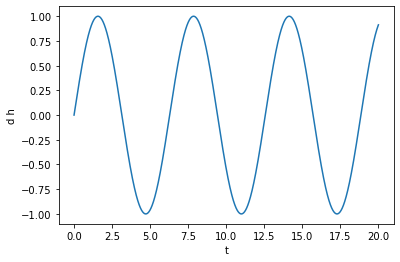

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

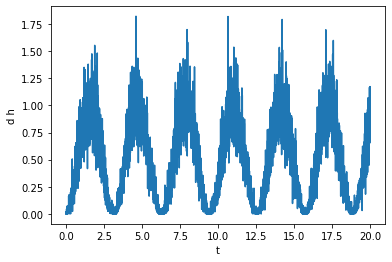

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

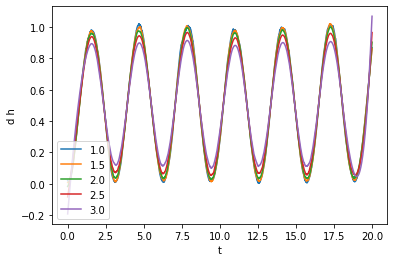

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

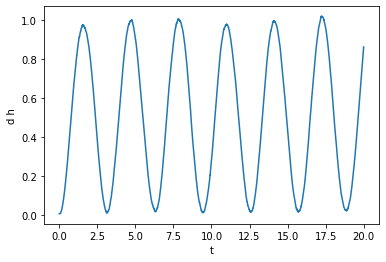

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1854


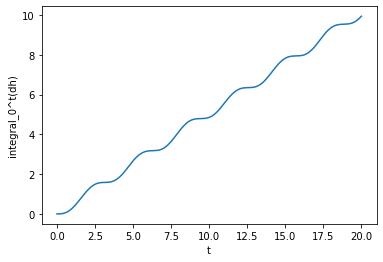

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

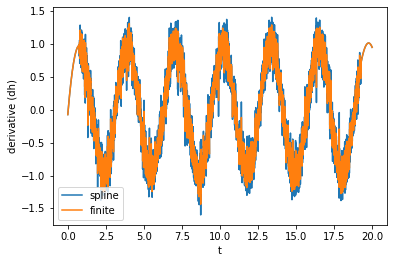

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

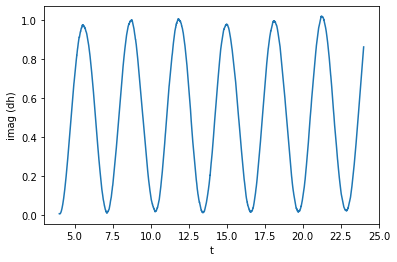

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

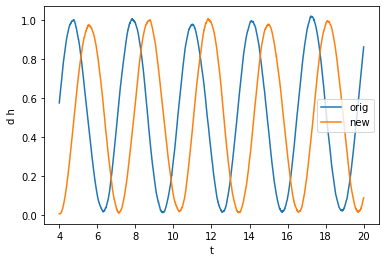

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

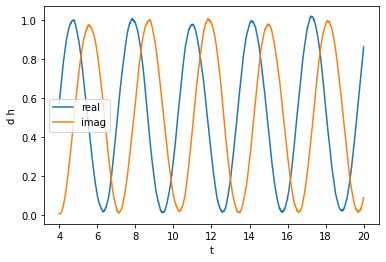

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

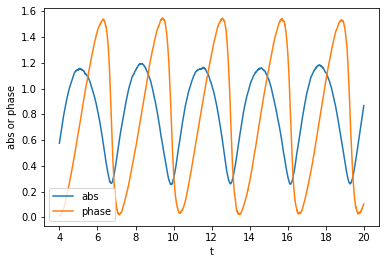

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

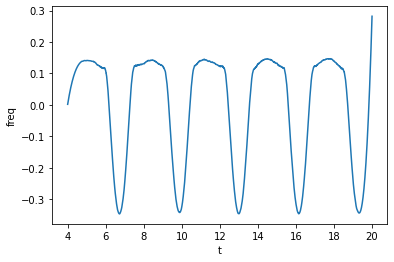

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

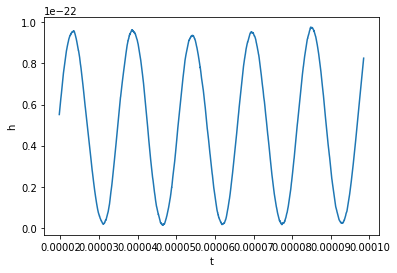

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

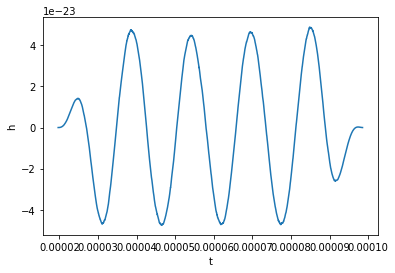

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

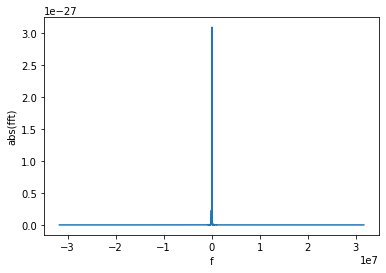

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

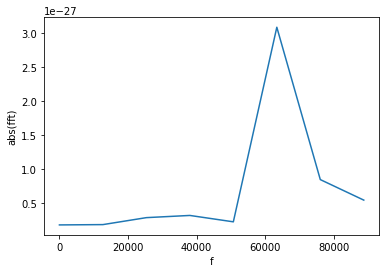

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64204.23


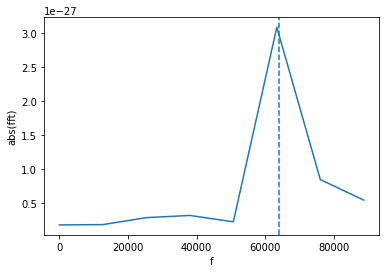

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.091e-27
Maximum with mask 8.449e-28
Length with mask 8
Length after having removed the masked points 7
